In [20]:
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [2]:
tickers=["SPY","BND","GLD","QQQ","VTI"]

In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

In [4]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker,start= start_date,end= end_date)
    adj_close_df[ticker] = data["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


The resulting log return values will represent the daily percentage changes in the adjusted closing prices of the financial asset or security.

In [5]:
log_return = np.log(adj_close_df/adj_close_df.shift(1))

In [6]:
log_return = log_return.dropna()

252 represents the approximate number of trading days in a year, assuming there are no holidays or weekends.

In [7]:
cov_matrix = log_return.cov()*252
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.046225,0.002290,0.003000,0.052557,0.047216
BND,0.002290,0.004167,0.003551,0.002860,0.002423
GLD,0.003000,0.003551,0.021920,0.004352,0.003156
QQQ,0.052557,0.002860,0.004352,0.068724,0.053659
VTI,0.047216,0.002423,0.003156,0.053659,0.048601


In [8]:
def std_dev (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [9]:
def exp_return(weights, log_return):
    return np.sum(log_return.mean()*weights*252)

In [10]:
def sharpe_ratio (weights, log_return, cov_matrix, risk_free_rate):
    return((exp_return(weights, log_return)-risk_free_rate)/std_dev (weights, cov_matrix))

In [11]:
from fredapi import Fred

Risk-free rate approximation: The risk-free rate represents the return an investor can expect to earn with certainty, without taking any risk. In practice, no investment is entirely risk-free, but certain government securities, like ten-year Treasury bonds, are considered to be very close to risk-free. These bonds are backed by the U.S. government, which is considered one of the most creditworthy entities in the world. As a result, the ten-year Treasury rate is often used as a practical approximation of the risk-free rate.

Long-term investment horizon: The ten-year Treasury rate is based on ten-year government bonds' yields, which means it represents a longer-term interest rate. The Sharpe Ratio is often used to assess the risk-adjusted performance of investments over extended periods, and using a long-term risk-free rate aligns with this investment horizon.

In [13]:
risk_free_rate = 0.02

fred = Fred(api_key="9ee5fbf7ac7d254b7ebcaff0633be1e4")
treasury_rate = fred.get_series_latest_release("GS10")/100

risk_free_rate = treasury_rate.iloc[-1]
print(risk_free_rate)

0.0375


Scipy.optimize.minimize() function is being used so we have to find the negative sharpe ration

In [14]:
def neg_sharpe_ratio (weights, log_return, cov_matrix, risk_free_rate):
    return(-sharpe_ratio(weights,log_return,cov_matrix,risk_free_rate))

In [15]:
constraints = {"type": "eq","fun": lambda weights: np.sum(weights)-1}
bounds = [(0,0.5) for _ in range(len(tickers))]

In [16]:
init_weights = np.array([1/len(tickers)]*len(tickers))
print(init_weights)

[0.2 0.2 0.2 0.2 0.2]


SLSQP stands for "Sequential Least Squares Programming," and it is a type of numerical optimization algorithm used to solve constrained nonlinear optimization problems. The SLSQP algorithm is particularly well-suited for problems with both equality and inequality constraints.

In the context of finance and portfolio optimization, SLSQP can be employed to find the optimal weights for different assets in a portfolio. The objective is typically to maximize returns while considering various constraints, such as risk tolerance, target return, and limits on the allocation to individual assets.

The algorithm starts with an initial set of weights and iteratively updates them to find the optimal solution. It employs a combination of gradient-based optimization techniques (utilizing derivatives) and quadratic programming to handle the constraints efficiently.

In [22]:
opti_results = minimize(neg_sharpe_ratio,init_weights,args=(log_return,cov_matrix,risk_free_rate),method="SLSQP", constraints=constraints,bounds=bounds)

print(opti_results)

     fun: -0.5699227735732176
     jac: array([-0.09319892,  0.02426337, -0.27441704, -0.20148151, -0.03582346])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([3.40005801e-16, 0.00000000e+00, 5.00000000e-01, 5.00000000e-01,
       2.08166817e-17])


In [23]:
optimal_weights = opti_results.x
print(optimal_weights)

[3.40005801e-16 0.00000000e+00 5.00000000e-01 5.00000000e-01
 2.08166817e-17]


In [19]:
print ("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print ()

optimal_portfolio_return = exp_return(optimal_weights, log_return)
optimal_portfolio_volatility = std_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_return, cov_matrix, risk_free_rate)

print (f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print (f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.0000
BND: 0.0000
GLD: 0.5000
QQQ: 0.5000
VTI: 0.0000

Expected Annual Return: 0.1273
Expected Volatility: 0.1576
Sharpe Ratio: 0.5699


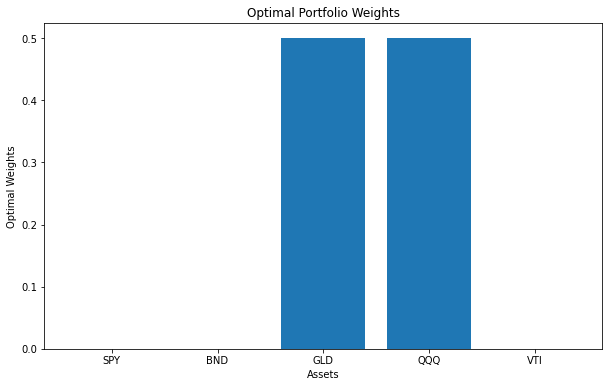

In [21]:
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

plt.xlabel("Assets")
plt.ylabel("Optimal Weights")
plt.title("Optimal Portfolio Weights")

plt.show()